In [1]:
from sklearn.externals import joblib # to save model

from P300.data import load_data

# confusion matrix
from sklearn import metrics
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


import matplotlib.pyplot as plt
%matplotlib inline 


%load_ext autoreload
%autoreload 2

import numpy as np

In [2]:
# load classifiers

#subject='B'
#subject='AandB'
model_folder = 'model'
subject='A'
num_ch=64
clf_filename_A="{}/{}_LR_ch{}.model".format(model_folder, subject, num_ch)
clf_A = joblib.load(clf_filename_A)
print(clf_A)

subject='B'
num_ch=64
clf_filename_B="{}/{}_LR_ch{}.model".format(model_folder, subject, num_ch)
clf_B = joblib.load(clf_filename_B)
print(clf_B)



LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [3]:
# fusion!
subject='A'
X_train, Y_train, Code_train = load_data(subject, 'train', 85)

loaded:
(85, 180, 896)
(85, 180, 1)
(85, 180, 1)
stacked:
(15300, 896)
(15300,)
(15300,)


In [4]:
clf_A.score(X_train,Y_train)

0.7696732026143791

In [5]:
clf_B.score(X_train,Y_train)

0.6529411764705882

## calc log prob

In [6]:
log_prob_A=clf_A.predict_log_proba(X_train)
log_prob_A_diff = log_prob_A[:,1]-log_prob_A[:,0]
log_prob_A_diff.shape

/Users/yyoo/tf11/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1434: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


(15300,)

In [7]:
log_prob_B=clf_B.predict_log_proba(X_train)
log_prob_B_diff = log_prob_B[:,1]-log_prob_B[:,0]
log_prob_B_diff.shape

/Users/yyoo/tf11/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1434: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


(15300,)

In [8]:
log_prob_diffs = np.stack((log_prob_A_diff,log_prob_B_diff),axis=1)
log_prob_diffs.shape

(15300, 2)

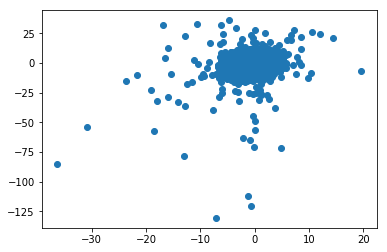

In [9]:
plt.plot(log_prob_diffs[:,0],log_prob_diffs[:,1],'o')

## train 2nd layer

In [10]:
idx_inf = np.any(np.isinf(log_prob_diffs),axis=1)
#idx_inf = np.any(np.isneginf(log_prob_diffs),axis=1)

print(log_prob_diffs[idx_inf,:])

print(Y_train[ idx_inf])


[[ -5.11668358          inf]
 [  0.46887119          inf]
 [  2.14147367          inf]
 [  4.57822421          inf]
 [ -3.09208049          inf]
 [  0.43831879          inf]
 [-16.22000305          inf]
 [-12.46601853          inf]
 [         inf  28.43875891]
 [  1.45266925          inf]
 [ -5.44915596          inf]
 [  9.9697619           inf]
 [  3.00616479          inf]
 [  7.25864026          inf]
 [ -4.0068317           inf]]
[-1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1]


In [11]:
print(log_prob_A[idx_inf,:])
print(log_prob_B[idx_inf,:])

[[-5.97797108e-03 -5.12266155e+00]
 [-9.54814709e-01 -4.85943522e-01]
 [-2.25255124e+00 -1.11077570e-01]
 [-4.58844492e+00 -1.02207131e-02]
 [-4.44066529e-02 -3.13648714e+00]
 [-9.36132177e-01 -4.97813385e-01]
 [-9.03113133e-08 -1.62200031e+01]
 [-3.85545914e-06 -1.24660224e+01]
 [           -inf  0.00000000e+00]
 [-1.66288560e+00 -2.10216351e-01]
 [-4.29071418e-03 -5.45344667e+00]
 [-9.96980869e+00 -4.67926091e-05]
 [-3.05446063e+00 -4.82958379e-02]
 [-7.25934407e+00 -7.03816995e-04]
 [-1.80274628e-02 -4.02485916e+00]]
[[           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [-2.84387589e+01 -4.45865567e-13]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  0.00000000e+00]
 [           -inf  

In [12]:
from sklearn.ensemble import RandomForestClassifier



clf = RandomForestClassifier(class_weight='balanced', n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
clf.fit(log_prob_diffs[~ idx_inf,:], Y_train[~ idx_inf].reshape(-1,1))

/Users/yyoo/tf11/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=16, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [13]:
num_ch = 64
joblib.dump(clf, "{}_LR_RF_ch{}.model".format(subject,num_ch))

['A_LR_RF_ch64.model']

In [14]:
clf.score(log_prob_diffs[~ idx_inf,:], Y_train[~ idx_inf])

0.7740268236833497